# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from LDMIBSS import *
from general_utils import *
from polytope_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
dim = 3
N = 10000
NumberofSources = dim
NumberofMixtures = 6

signed_dims = np.array([0,1])
nn_dims = np.array([2])
sparse_dims_list = [np.array([0,1]),np.array([1,2])]
(A,b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)
S = generate_uniform_points_in_polytope(V, N)

Text(0.5, 0.98, 'Scatter Plot of Source Components')

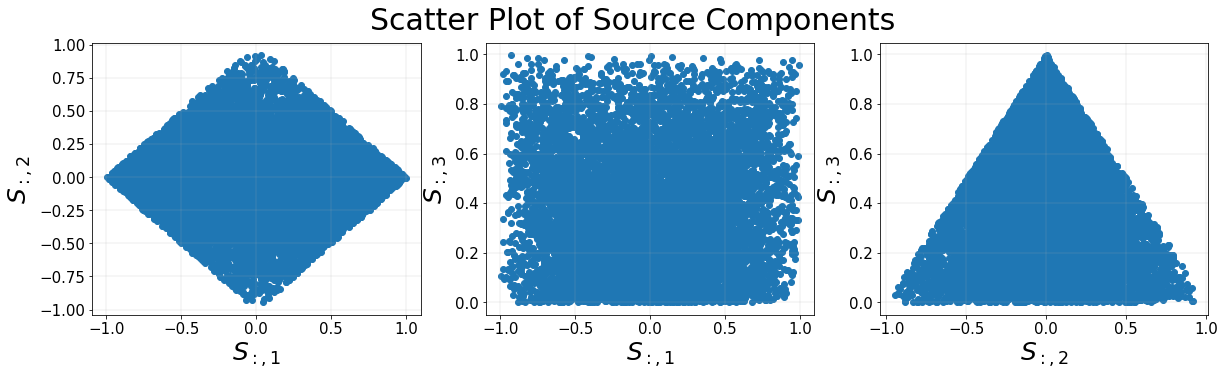

In [4]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.scatter(S[0,:], S[1,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,2}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,2)
plt.scatter(S[0,:], S[2,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,3)
plt.scatter(S[1,:], S[2,:])
plt.xlabel("$S_{:,2}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)

plt.suptitle("Scatter Plot of Source Components", fontsize = 30)
# plt.savefig('Pex_source_components.pdf', format='pdf', dpi = 1200)

In [5]:
# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.010819266116194


# Visualize Generated Sources and Mixtures

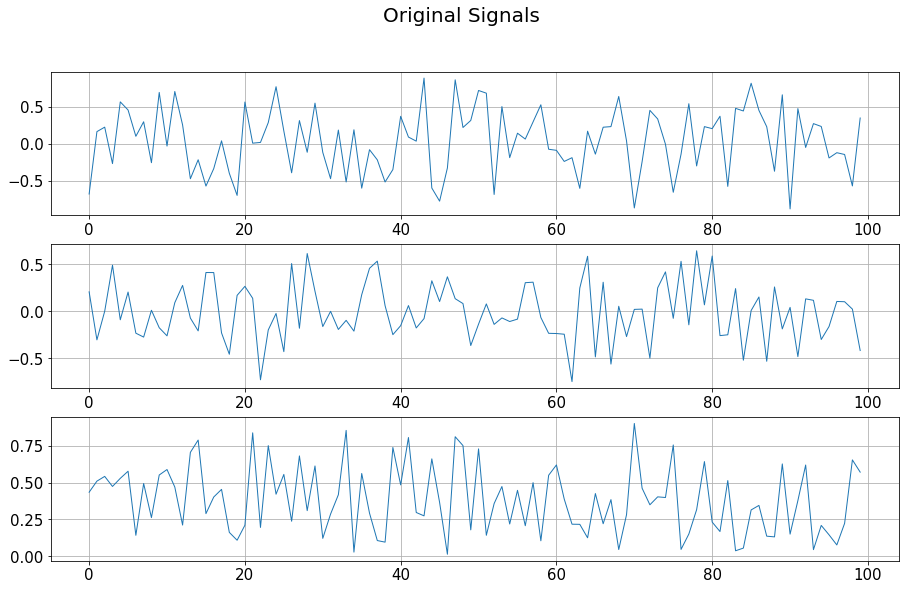

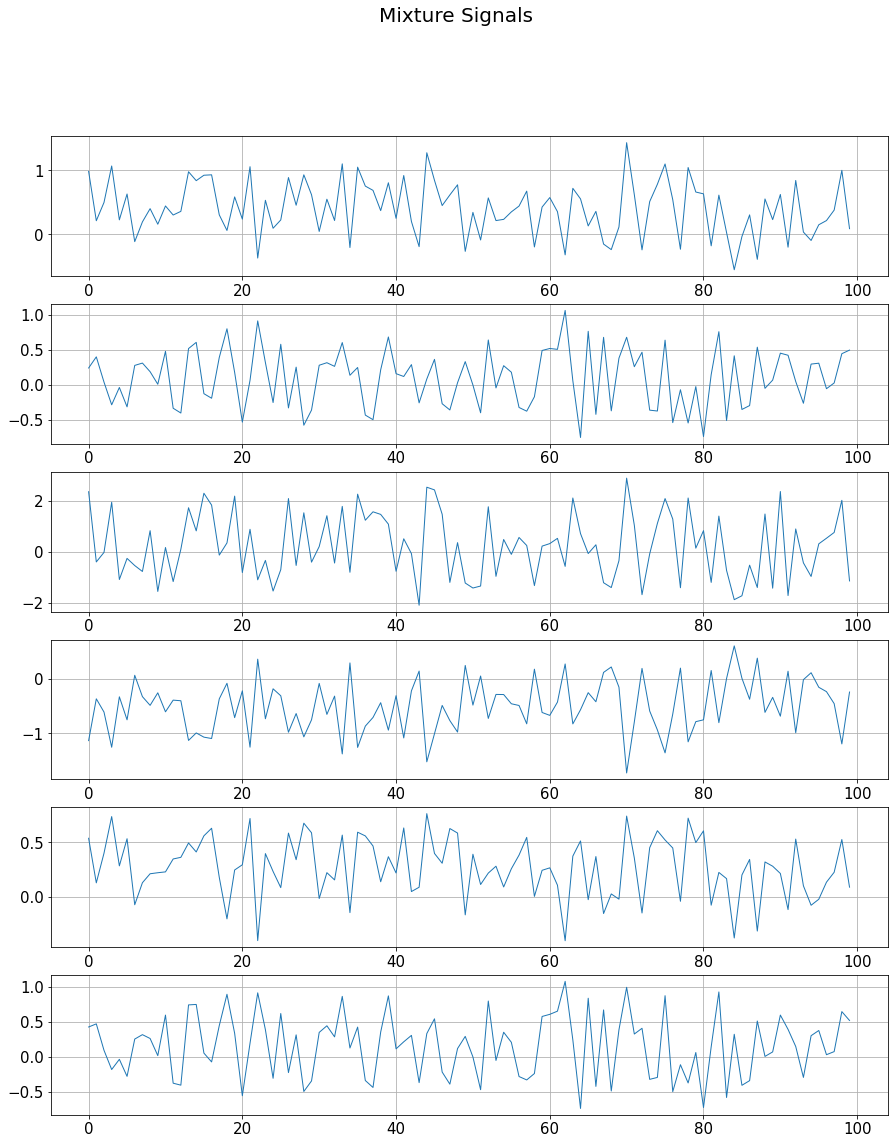

In [6]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [7]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 1000
model = LDMIBSS(s_dim = s_dim, x_dim = x_dim,
                set_ground_truth = True, S = S, A = A)

# Run LDMI Algorithm on Mixture Signals

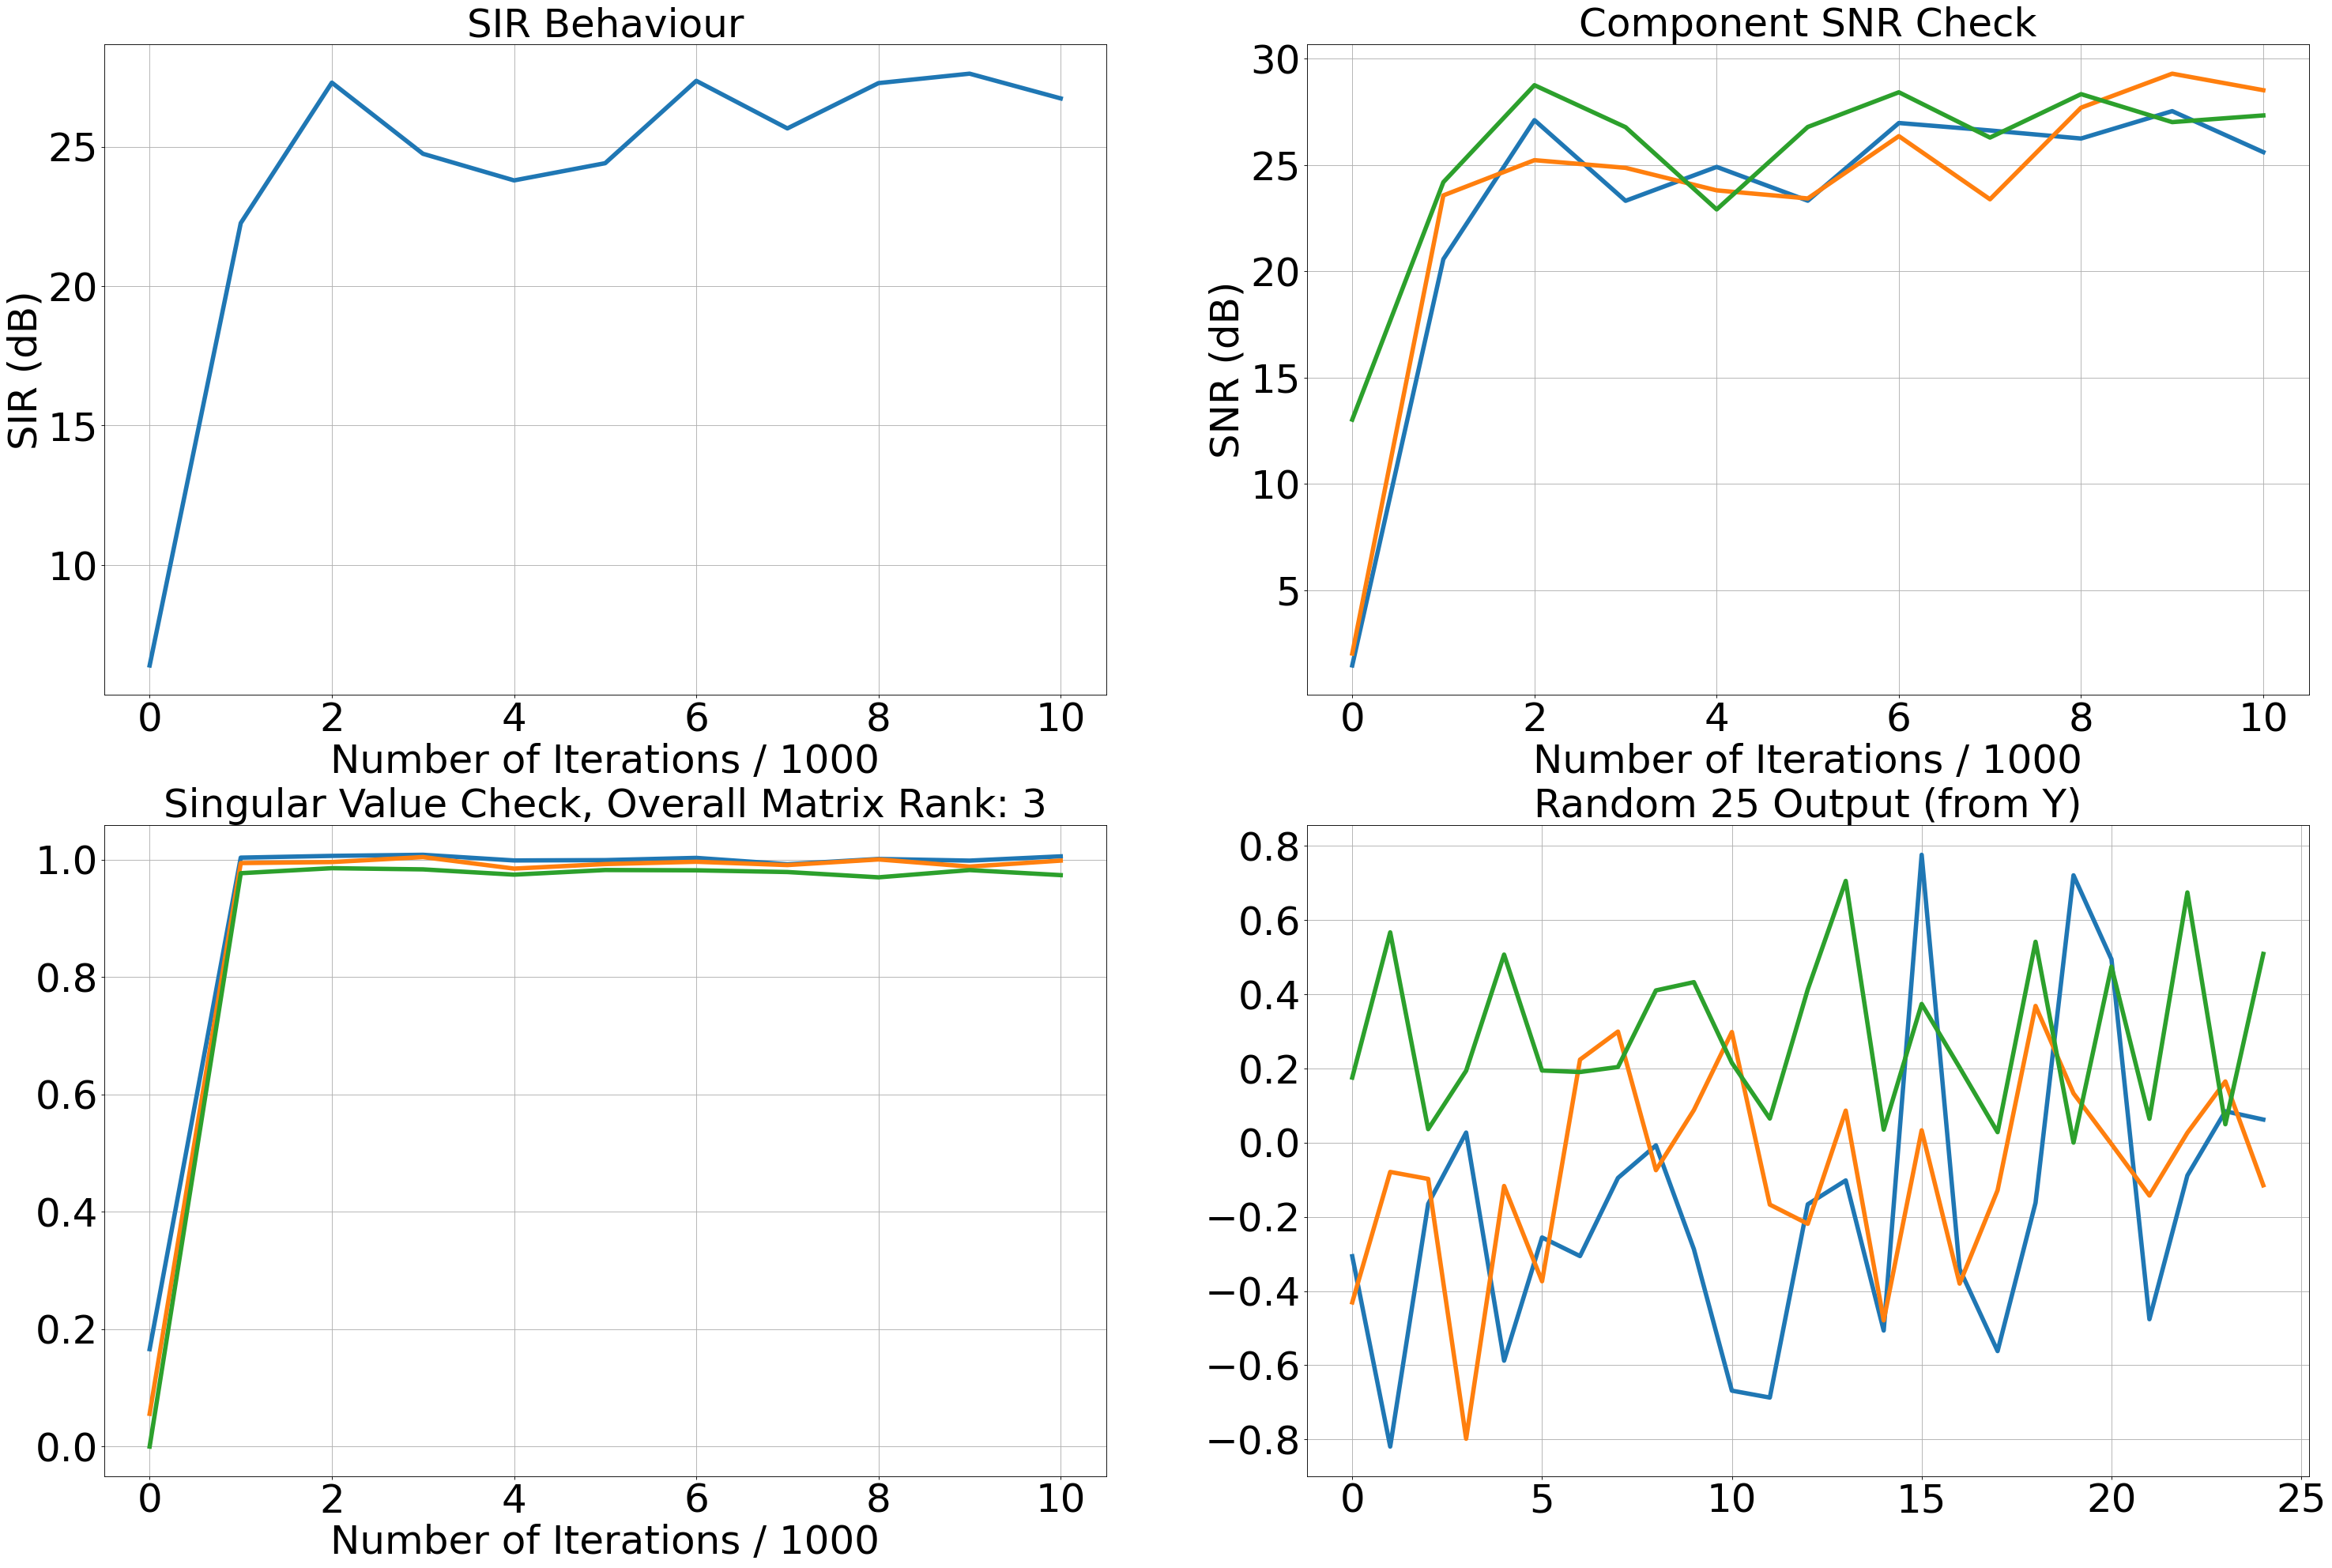

100%|██████████| 10000/10000 [02:08<00:00, 77.59it/s]


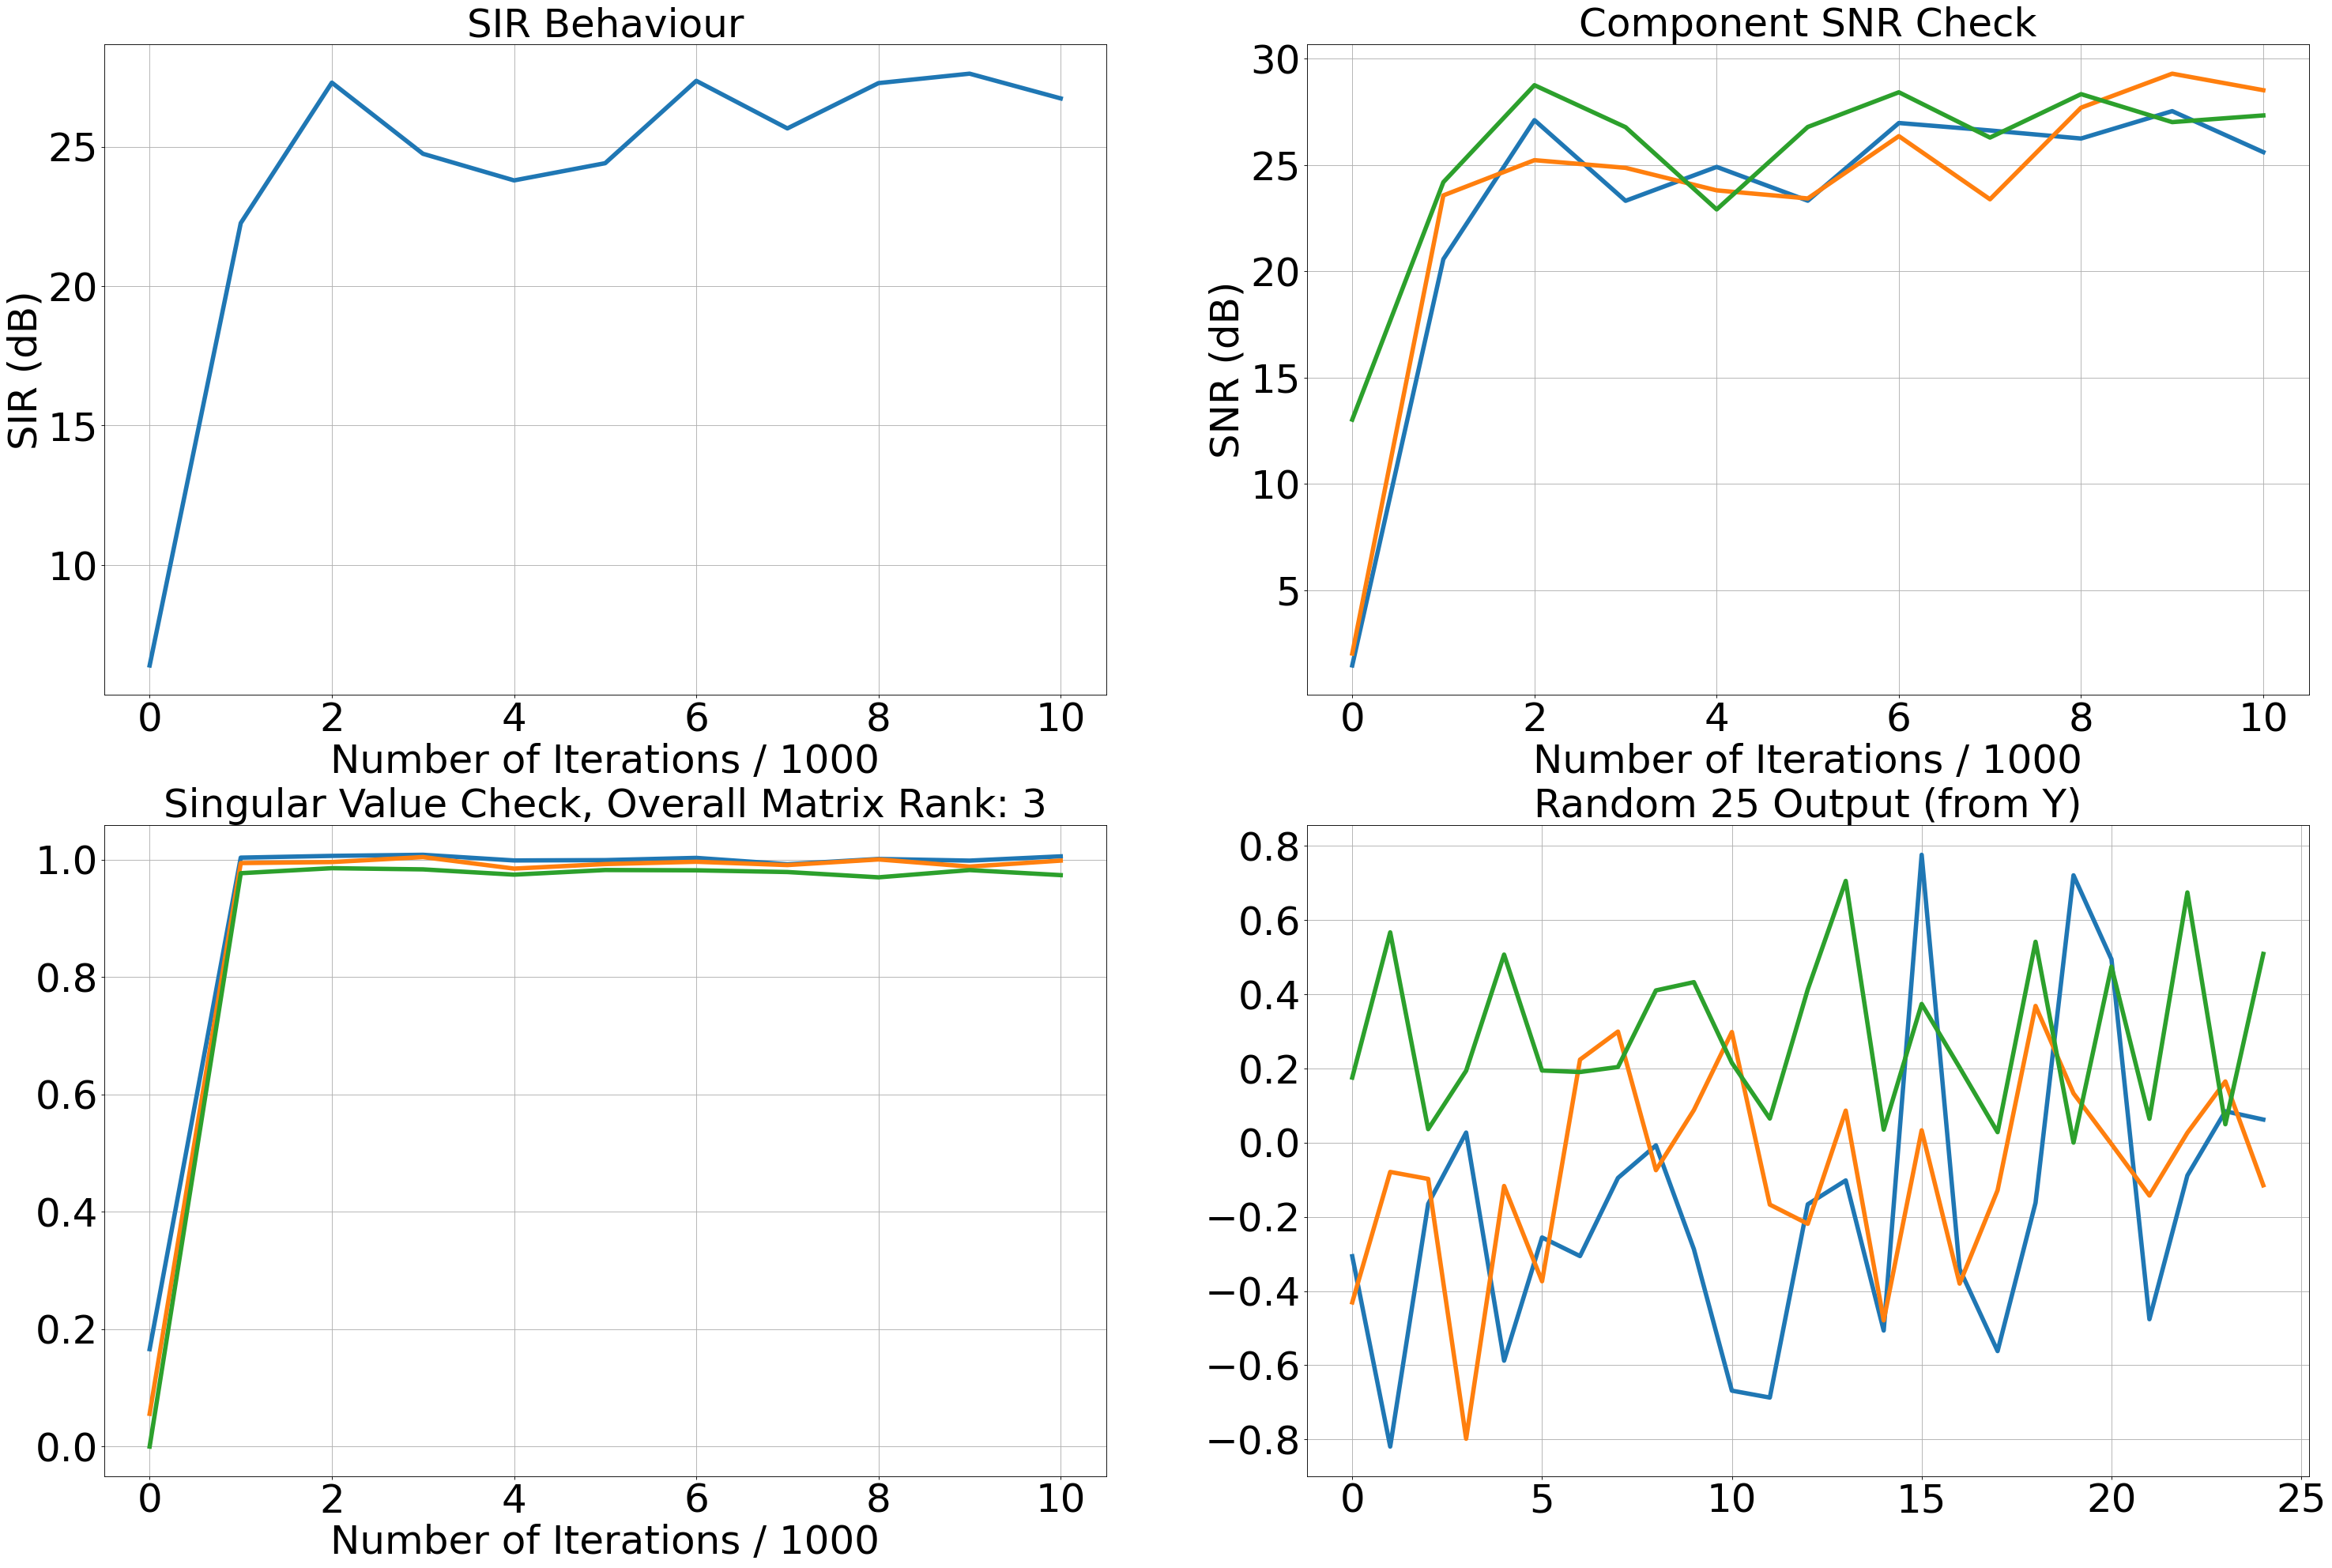

In [8]:
model.fit_batch_general_polytope(X, signed_dims, nn_dims, sparse_dims_list,
                                 epsilon = 1e-5, mu_start = 200, n_iterations = 10000, 
                                 method = "correlation", lr_rule = "inv_sqrt",
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True)

# Calculate Resulting Component SNRs and Overall SINR

In [9]:
Wf = model.W
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S, False)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [27.37200736 30.67506694 29.93100511]

Overall SINR : 28.83229365227793


# Vizualize Extracted Signals Compared to Original Sources

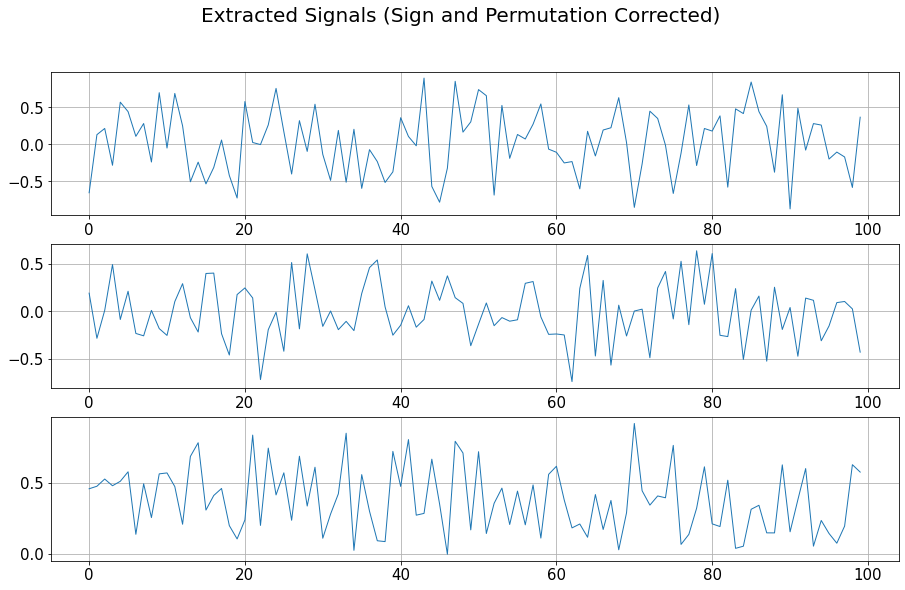

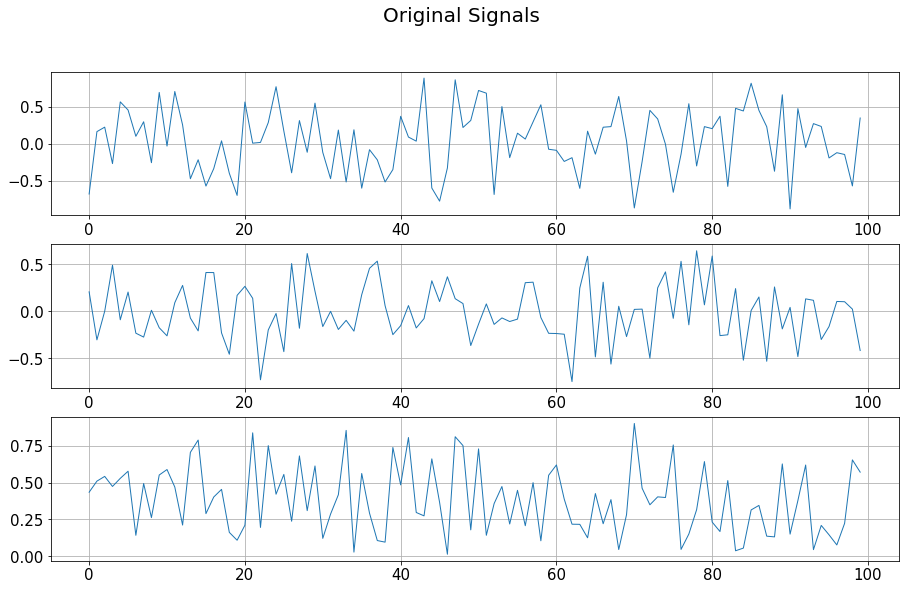

In [10]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)